# 機械学習と深層学習の融合: 手持ち画像の分類事例

以下ではmahotasパッケージを使い画像分類を試みます。この例では、青野が撮影した約2500枚の画像（20種類の植物）からなる画像データを用いて機械学習を行い、画像分類します。

以下のデータをdownloadし、展開しておいてください。(270MBくらいあります）

http://www.tutarc.org/Seminar/Python/download/myPlants2.zip

深層学習だけでも、十分精度が高くなります。一方で、伝統的な機械学習は、単独では精度が低いものの、
深層学習と相補的に利用することもできます。ここでは、相補的な利用例で、深層学習で得られる分類精度を
さらに、1～2%向上することを目指します。


# 以下の手順で進めます

<pre>
 (0) 訓練データ画像とテストデータ画像の読込み
 (1) 色特徴量（ヒストグラム）とテクスチャ特徴量の抽出（"i-feature")
 (2) SURF特徴量の抽出
 (3) SURF特徴量をk-means法でクラスタリング
 (4) クラスタリングされたSURF特徴量からBoVW特徴量の抽出 ("s-feature")
 (5) "i-feature"から2層のMLPで植物画像分類
 (6) "s-feature"から2層のMLPで植物画像分類
 (7) "s-feature"からSVMで植物画像分類（MLPとSVMの精度比較のため）
 (8) "i-feature"と"s-feature"の融合特徴量（si-feature）で植物画像分類
 (9) VGG16(ImageNetで訓練済みDNN)のfc2層から4096次元の特徴量を抽出 ("fc2-feature")
(10) "fc2-feature"から2層のMLPで植物画像分類
(11) "fc2-feature"と"si-feature"を融合（"merged-feature") 
(12) "merged-feature"で植物画像分類
</pre>


In [1]:
# 今回の20種類の植物
classes = ['Ajisai', 'Egonoki', 'Hinoki', 'Ichou', 'Itayakaede',
	'Keyaki', 'Konara', 'Kunugi', 'Kusunoki', 'Kuwa',
	'Matsu', 'Mizuki', 'Nankinhaze', 'Pratanus', 'Sakura',
	'Sazanka', 'Sennoki', 'Sugi', 'Tsutsuji', 'Yuri']

In [2]:
# 訓練画像とそのインデックスをアルファベット順に呼び出すたびに返す関数
from glob import glob
import numpy as np
train_basedir = 'C:/Users/jtcuser/DeepLearning/data/myPlantPhoto/Training'
def train_images():
    for (i,x) in enumerate(classes):
        images = glob('{}/{}/*.jpg'.format(train_basedir, x))
        for im in sorted(images):
            yield im,i

In [3]:
# テスト画像とそのインデックスをアルファベット順に呼び出すたびに返す関数
from glob import glob
import numpy as np
test_basedir = 'C:/Users/Aono/DeepLearning/data/myPlantPhoto/Testing'
def test_images():
    for (i,x) in enumerate(classes):
        images = glob('{}/{}/*.jpg'.format(test_basedir, x))
        for im in sorted(images):
            yield im,i

In [4]:
# テスト画像のファイルリストを作成（flistに保持）
flist = []
labels = []
for (im,label) in test_images():
    flist.append(im)
    labels.append(label)

In [5]:
# 画像から色ヒストグラムを作成する関数
import numpy as np

def chist(im):
    '''色ヒストグラム (chist)
    パラメータ： im : ndarray (RGB image)
    出力：c : ndarray (1-D array of histogram values)'''

    # Downsample pixel values:
    im = im // 64

    # RGBチャネルをｖ分離
    r,g,b = im.transpose((2,0,1))

    pixels = 1 * r + 4 * g + 16 * b
    # 64個のビンのヒストグラムを生成し、ピクセル値でカウントアップ
    hist = np.bincount(pixels.ravel(), minlength=64) 
    hist = hist.astype(float) # 整数を実数に変換
    return np.log1p(hist) #ヒストグラムの各要素に1足した自然対数


In [6]:
# 画像からHaralickテクスチャーを計算する関数

import mahotas as mh
import numpy as np

def h_texture(im): # Haralick texture
    '''テクスチャー (texture)
    パラメータ： im : ndarray (RGB image)
    出力：c : ndarray (1-D array of texture statistical values)'''   
    img = mh.colors.rgb2grey(im).astype(np.uint8)
    # Haralickテクスチャ特徴量(4x13)+64次元カラーヒストグラム->116次元
    # 4 = (0度, 45度, 90度, 135度)
    chk = mh.features.haralick(img).ravel()
    return chk

In [7]:
# 色特徴量とテクスチャ特徴量を連結（i-featureを返す）
def features_for(im):
    im = mh.imread(im)
    cch = chist(im) # 色ヒストグラム
    chk = h_texture(im) # Haralickテクスチャー

    f_f = np.concatenate([chk, cch])# 連結
    return f_f

In [8]:
# 訓練画像の色テクスチャ特徴量計算
print('訓練画像の色テクスチャ特徴量計算開始...')
train_ifeatures = []
train_labels = []
count = 0
for im, ell in train_images():
    train_ifeatures.append(features_for(im))
    train_labels.append(ell)
    count += 1
    if (count % 400 == 0):
        print("訓練画像色テクスチャ特徴量 processing ",count," images...")

train_ifeatures = np.array(train_ifeatures)
train_labels = np.array(train_labels)
print ('訓練データのi-featureのシェープ = ',train_ifeatures.shape)

訓練画像の色テクスチャ特徴量計算開始...
訓練画像色テクスチャ特徴量 processing  400  images...
訓練画像色テクスチャ特徴量 processing  800  images...
訓練画像色テクスチャ特徴量 processing  1200  images...
訓練データのi-featureのシェープ =  (1400, 116)


In [9]:
print('テスト画像のテクスチャ特徴量計算開始...')
test_ifeatures = []
test_labels = []
for im, ell in test_images():
    test_ifeatures.append(features_for(im))
    test_labels.append(ell)

test_ifeatures = np.array(test_ifeatures)
test_labels = np.array(test_labels)
print ('テストデータのi-featureのシェープ = ',test_ifeatures.shape)

テスト画像のテクスチャ特徴量計算開始...
テストデータのi-featureのシェープ =  (0,)


In [10]:
# i-featureをNumpy形式で保存
np.save('npy/Python-ML-DL-Fusion-Train-ifeature.npy', train_ifeatures)
np.save('npy/Python-ML-DL-Fusion-Test-ifeature.npy', test_ifeatures)

# SURF特徴量の計算

In [11]:
from mahotas.features import surf

print('SURF局所特徴量を計算...')
train_descriptors = []
count = 0
for im,_ in train_images():
    im = mh.imread(im, as_grey=True) # グレースケール画像として特徴量計算
    im = im.astype(np.uint8)
    count += 1
    if (count % 300 == 0):
        print("局所特徴量　processing ",count," images...")
    train_descriptors.append(surf.surf(im, descriptor_only=True))

print('SURF特徴量　計算完了. length=',len(train_descriptors))

SURF局所特徴量を計算...
局所特徴量　processing  300  images...
局所特徴量　processing  600  images...
局所特徴量　processing  900  images...
局所特徴量　processing  1200  images...
SURF特徴量　計算完了. length= 1400


In [12]:
# SURF特徴量を連結し、Numpy形式で保存

concatenated = np.concatenate(train_descriptors) # SURF特徴量を連結してndarrayに変換
print('記述子の次元: {}'.format(len(concatenated)))

np.save('npy/Python-ML-DL-Fusion-Cat-sfeature.npy', 
        concatenated) #Numpy形式でファイルに出力


記述子の次元: 1192227


In [13]:
# K-meansクラスタリング（時間がかかる）
# 全部を使うのでなく、部分集合（64個おきにデータをサンプリング）で行う
# クラスターは256個とする
from sklearn.cluster import KMeans
k = 256
km = KMeans(k)

concatenated = concatenated[::64] # 64個ずつのベクトルだけ用いて高速化

print('K-meansでクラスタリング...（データシェープ：', concatenated.shape,')')
kmeans_fit = km.fit(concatenated)


K-meansでクラスタリング...（データシェープ： (18629, 64) )


In [14]:
# クラスタリング結果をPickleで保存

import pickle
pickle.dump(km, open('pkl/Python-ML-DL-Fusion-K-means.pkl','wb'))
pickle.dump(kmeans_fit, open('pkl/Python-ML-DL-Fusion-K-means-fit.pkl','wb'))


In [15]:
print('テスト画像のSURF局所特徴量を計算...')
test_descriptors = []
for im,_ in test_images():
    im = mh.imread(im, as_grey=True)
    im = im.astype(np.uint8)

    # テスト画像のSURF局所特徴量を計算:
    test_descriptors.append(surf.surf(im, descriptor_only=True))# 通常のSURFの場合
    

テスト画像のSURF局所特徴量を計算...


In [16]:
# テスト画像ファイル名リストの作成
test_file_list = []
for im,_ in test_images():
    test_file_list.append(im)
    

# BoW特徴量の計算

In [16]:
train_sfeatures = []
k = 256
for d in train_descriptors:
    c = km.predict(d)
    train_sfeatures.append(np.bincount(c, minlength=k)) # ヒストグラムのカウント

# 訓練データのBoVW特徴量（ヒストグラム）
train_sfeatures = np.array(train_sfeatures, dtype=float) #リストからNumpy配列に変換
print ('訓練データ：s-featureのシェープ = ',train_sfeatures.shape)

# 訓練データのBoVW特徴量と色テクスチャー特徴量のマージ
print('訓練データ　s-featureとi-featureのマージ...')
train_allfeatures = np.hstack([train_sfeatures, train_ifeatures])
print ('訓練データ：マージされたsi-featureのシェープ = ',train_allfeatures.shape)

訓練データ：s-featureのシェープ =  (1400, 256)
訓練データ　s-featureとi-featureのマージ...
訓練データ：マージされたsi-featureのシェープ =  (1400, 372)


In [17]:
test_sfeatures = []
k = 256
for d in test_descriptors:
    c = km.predict(d)
    test_sfeatures.append(np.bincount(c, minlength=k))

# テストデータのBoVW特徴量（ヒストグラム）
test_sfeatures = np.array(test_sfeatures, dtype=float)
print ('テストデータ：s-featureのシェープ = ',test_sfeatures.shape)

# テストデータのBoVW特徴量と色テクスチャー特徴量のマージ
print('テストデータ　s-featureとi-featureのマージ...')
test_allfeatures = np.hstack([test_sfeatures, test_ifeatures])
print ('テストデータ：マージされたsi-featureのシェープ = ',test_allfeatures.shape)


テストデータ：s-featureのシェープ =  (200, 256)
テストデータ　s-featureとi-featureのマージ...
テストデータ：マージされたsi-featureのシェープ =  (200, 372)


In [18]:
# BoVW特徴量をNumpy形式でファイルに保存 
np.save('npy/Python-ML-DL-Fusion-Train-BoVW.npy', train_sfeatures)
np.save('npy/Python-ML-DL-FUsion-Test-BoVW.npy', test_sfeatures)


# ここからニューラルネット（Keras）利用開始

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6  #60%
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session) 

Using TensorFlow backend.


# Image Feature (Color Histogram + Haralick Texture)

# i-featureにニューラルネット適用

In [20]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
import numpy as np
from keras.utils import np_utils 

i_model = Sequential()
i_model.add(Dense(32,input_dim=116))# 入力は116次元
i_model.add(BatchNormalization())
i_model.add(Activation('tanh'))
i_model.add(Dropout(0.5))
i_model.add(Dense(20,activation='softmax'))
i_compile = i_model.compile(optimizer='rmsprop',
                           loss='categorical_crossentropy', 
                           metrics=['accuracy']) 
i_model.summary() # 重みパラメータはだいたい4500個

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                3744      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                660       
Total params: 4,532
Trainable params: 4,468
Non-trainable params: 64
_________________________________________________________________


In [21]:
# 色テクスチャー特徴量だけでの訓練開始
NB_CLASSES = 20
my_label = np_utils.to_categorical(train_labels, NB_CLASSES)
i_fit = i_model.fit(train_ifeatures, my_label, epochs=200, batch_size=32) 


Epoch 1/200
1400/1400 [==============================] - 0s 246us/step - loss: 3.2472 - acc: 0.0593
Epoch 2/200
1400/1400 [==============================] - 0s 45us/step - loss: 3.1319 - acc: 0.0657
Epoch 3/200
1400/1400 [==============================] - 0s 50us/step - loss: 3.0183 - acc: 0.0914
Epoch 4/200
1400/1400 [==============================] - 0s 50us/step - loss: 3.0339 - acc: 0.0929
Epoch 5/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.9905 - acc: 0.0893
Epoch 6/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.9768 - acc: 0.0857
Epoch 7/200
1400/1400 [==============================] - 0s 52us/step - loss: 2.9263 - acc: 0.1157
Epoch 8/200
1400/1400 [==============================] - 0s 48us/step - loss: 2.8705 - acc: 0.1236
Epoch 9/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.7980 - acc: 0.1421
Epoch 10/200
1400/1400 [==============================] - 0s 47us/step - loss: 2.7928 - acc: 0.1457
Epoch 11

1400/1400 [==============================] - 0s 49us/step - loss: 2.1638 - acc: 0.3043
Epoch 84/200
1400/1400 [==============================] - 0s 50us/step - loss: 2.1873 - acc: 0.3214
Epoch 85/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.1624 - acc: 0.3279
Epoch 86/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.1322 - acc: 0.3429
Epoch 87/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.1280 - acc: 0.3586
Epoch 88/200
1400/1400 [==============================] - 0s 48us/step - loss: 2.1601 - acc: 0.3321
Epoch 89/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.1487 - acc: 0.3371
Epoch 90/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.1585 - acc: 0.3471
Epoch 91/200
1400/1400 [==============================] - 0s 51us/step - loss: 2.1599 - acc: 0.3350
Epoch 92/200
1400/1400 [==============================] - 0s 50us/step - loss: 2.1151 - acc: 0.3457
Epoch 93/200


In [22]:
# 色テクスチャー特徴量でのモデルと重みをHDF5形式で保存
i_model.save('h5/Python-ML-DL-Fusion-ifeatures-NN-model.h5')
i_model.save_weights('h5/Python-ML-DL-Fusion-ifeatures-NN-weights.h5')

In [23]:
# 色テクスチャー特徴量での未知データのクラス分類（推定）
i_pred = i_model.predict_classes(test_ifeatures, batch_size=32, verbose=1)
print(i_pred)

200/200 [==============================] - 0s 180us/step
[ 9  0  3  0  0  0  0  0  3  0  9  3  7  1  0  0  3  3  1  1  3  3  3 10
  3  3  3 10  7  3  3  3  3  3  3  3 11  3  3  3  0  3  3  4  3  7  3  3
  9  9  3  3  3  3  3  3  9  5  3  3  3  3  3  3  3 10  3  3  3  3  7  3
  3 12  3  3  3  1 10  3  8 13  3  4 10  7  3 12  4  3  9  9  9  9  9  0
  9  9  3  3  3 10  3  3  3  3  3  3 10  3  3  5  3  3 11 11  3  3 12  9
 12 12  3  3  7  3  9  3 11 12  3  3  9  3  7  3  3  9  3  9 14 14 14 14
  3  3  3 14 13  3 15 15 15 15 15 15 15 15  3 15 14  3  3 11  3  3  3 14
  4  3  6  6  3  3  3  3  3  3  3  9  0 18 18  0 15 18 18 15  3 15 12 12
  3  3  3  3  3 19 19 19]


In [24]:
# 色テクスチャー特徴量での未知データのクラス分類確率
i_pred_P = i_model.predict(test_ifeatures)
print(i_pred_P)

# 分類確率をNumpy形式で保存
np.save('npy/Python-ML-DL-Fusion-ifeature-predict.npy',i_pred_P)

[[1.14216395e-01 7.08398744e-02 3.05768591e-03 ... 5.95536502e-03
  6.77731633e-03 1.88625045e-02]
 [2.92509019e-01 3.43875960e-02 4.82484326e-03 ... 8.09539482e-03
  1.45852454e-02 8.94331038e-02]
 [1.53812438e-01 2.87507586e-02 5.46136405e-03 ... 1.22250002e-02
  1.92948245e-02 1.12777790e-02]
 ...
 [4.96344175e-03 6.57771574e-03 1.70045882e-04 ... 2.81245448e-04
  1.04269930e-04 9.68682587e-01]
 [1.12362299e-02 2.44198665e-02 1.74266542e-03 ... 3.57643678e-03
  3.35570687e-04 7.72426426e-01]
 [1.32623419e-01 3.28552723e-02 2.78905593e-03 ... 5.60612371e-03
  6.18117023e-03 2.71909803e-01]]


In [25]:
# 混合行列の描画関数の定義
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=25)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

Confusion matrix, without normalization
[[7 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0]
 [0 3 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 3 7 9 5 8 9 6 3 2 8 5 4 6 4 1 6 7 1 5]
 [0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 2 1 0 0 0 7 0 1 1 3 0 0 0 1 0 0]
 [0 0 2 0 0 0 1 1 1 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 2 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 1 3 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]


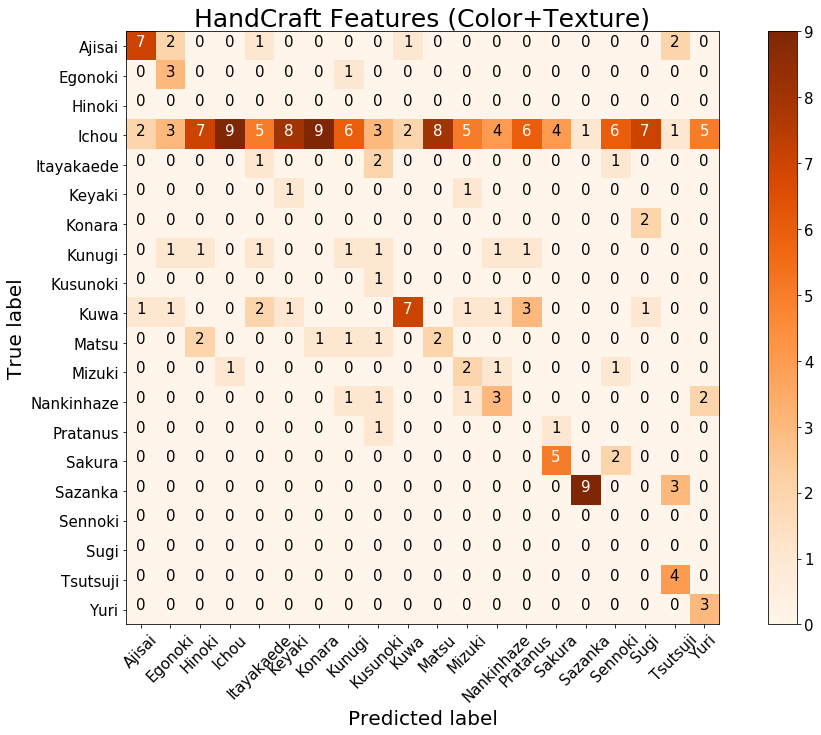

In [26]:
# 色テクスチャー特徴量での混合行列の計算と表示
actual = test_labels
i_cm = confusion_matrix(i_pred, actual)
plot_confusion_matrix(i_cm, classes=classes, title='HandCraft Features (Color+Texture)')
plt.show()

In [27]:
# 色テクスチャー特徴量だけでの全体の平均分類精度の計算
actual = test_labels

count = 0
total = len(actual)
for i in range(total):
    if actual[i] == i_pred[i]:
        count += 1
accuracy = float(count)/total
print("分類精度：色とテクスチャー特徴量(ifeatures) = ",accuracy) # Previously 0.36

分類精度：色とテクスチャー特徴量(ifeatures) =  0.29


# BoVW 特徴量

# s-featureにニューラルネット適用

In [28]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation 
import numpy as np
from keras.utils import np_utils 

s_model = Sequential()
s_model.add(Dense(64,input_dim=256)) # 乳直は256次元のBoVW特徴量のみ
s_model.add(Activation('tanh'))
s_model.add(Dropout(0.5))
s_model.add(Dense(20,activation='softmax'))
s_compile = s_model.compile(optimizer='rmsprop',
                           loss='categorical_crossentropy', 
                           metrics=['accuracy']) 
s_model.summary() # 重みパラメータはだいたい18000程度


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1300      
Total params: 17,748
Trainable params: 17,748
Non-trainable params: 0
_________________________________________________________________


In [29]:
# BoVW特徴量だけでの訓練開始
NB_CLASSES = 20
my_label = np_utils.to_categorical(train_labels, NB_CLASSES)
s_fit = s_model.fit(train_sfeatures, my_label, epochs=200, batch_size=32) 

Epoch 1/200
1400/1400 [==============================] - 0s 149us/step - loss: 3.7350 - acc: 0.0650
Epoch 2/200
1400/1400 [==============================] - 0s 48us/step - loss: 3.2883 - acc: 0.0850
Epoch 3/200
1400/1400 [==============================] - 0s 49us/step - loss: 3.1170 - acc: 0.1271
Epoch 4/200
1400/1400 [==============================] - 0s 48us/step - loss: 2.9047 - acc: 0.1650
Epoch 5/200
1400/1400 [==============================] - 0s 50us/step - loss: 2.8235 - acc: 0.1771
Epoch 6/200
1400/1400 [==============================] - 0s 105us/step - loss: 2.6810 - acc: 0.2121
Epoch 7/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.5428 - acc: 0.2421
Epoch 8/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.5191 - acc: 0.2393
Epoch 9/200
1400/1400 [==============================] - 0s 50us/step - loss: 2.3798 - acc: 0.2886
Epoch 10/200
1400/1400 [==============================] - 0s 49us/step - loss: 2.3485 - acc: 0.2829
Epoch 1

1400/1400 [==============================] - 0s 48us/step - loss: 0.3994 - acc: 0.8700
Epoch 164/200
1400/1400 [==============================] - 0s 49us/step - loss: 0.3923 - acc: 0.8779
Epoch 165/200
1400/1400 [==============================] - 0s 49us/step - loss: 0.4329 - acc: 0.8514
Epoch 166/200
1400/1400 [==============================] - 0s 47us/step - loss: 0.4292 - acc: 0.8629
Epoch 167/200
1400/1400 [==============================] - 0s 49us/step - loss: 0.4145 - acc: 0.8636
Epoch 168/200
1400/1400 [==============================] - 0s 47us/step - loss: 0.3876 - acc: 0.8807
Epoch 169/200
1400/1400 [==============================] - 0s 49us/step - loss: 0.4022 - acc: 0.8657
Epoch 170/200
1400/1400 [==============================] - 0s 49us/step - loss: 0.3933 - acc: 0.8757
Epoch 171/200
1400/1400 [==============================] - 0s 48us/step - loss: 0.3994 - acc: 0.8693
Epoch 172/200
1400/1400 [==============================] - 0s 49us/step - loss: 0.4046 - acc: 0.8657
Epoc

In [30]:
# BoVW特徴量でのモデルと重みをHDF5形式で保存
s_model.save('h5/Python-ML-DL-Fusion-sfeature-model.h5')
s_model.save_weights('h5/Python-ML-DL-Fusion-sfeatures-weights.h5')

In [31]:
# BoVW特徴量での未知データのクラス分類（推定）
s_pred = s_model.predict_classes(test_sfeatures, batch_size=32, verbose=1)
print(s_pred)

200/200 [==============================] - 0s 170us/step
[ 8  0  0 15  0  0  0  7 13 16  9  4  1  1  1  1  3  1  0 15  2  2  2 17
  2  2  2 11 17  2  3  3 11  3 10  3  3  3  3 13 19  4 11  8 16 11  4 10
  7  4  5  5  5 16  5  5  5  5  5  5  6  0  4 18 16  6  3  9 10  3  7 12
  7 13 16  0 10  1 16  9  8  8  8  7  8 16  8  8 11  8  9 14 18  9 14  9
  6  9 12  9 10 10  7 10 10  6 10 10 10 12 18 11 11 11 16 11  8  5  3 11
 18 12 12  8 11 11  9 12 16  4 13 13 16 13 16 19  3  5 13 15  1  4 14  3
 14 14  9 14  9  1 15 15 15 15 15 15 12  1 15 15 12  3 16  8 16  6 10 11
 14 17 17  8 15 17 17 17 12 17  3 17 18 18 15 18 18  2  4 18 14 18 19  2
 19 19 19 19 19 19 19 19]


In [32]:
# BoVW特徴量での未知データのクラス分類確率
s_pred_P = s_model.predict(test_sfeatures)
print(s_pred_P)
print(type(s_pred_P))
# 分類確率をNumpy形式で保存
np.save('npy/Python-ML-DL-Fusion-sfeature-predict.npy',s_pred_P)

[[1.8427441e-01 5.3753513e-03 3.3288325e-06 ... 1.7667994e-04
  8.1864661e-03 2.5684332e-05]
 [5.0323713e-01 1.1093660e-03 2.1951812e-06 ... 1.2006968e-05
  2.7628380e-03 1.6762048e-04]
 [9.9728608e-01 2.9884957e-05 1.0808105e-08 ... 3.9344766e-08
  1.5939989e-04 1.9639176e-06]
 ...
 [1.6810325e-06 2.3688569e-06 2.6713922e-03 ... 1.2588671e-04
  1.5668773e-05 9.9370569e-01]
 [4.8473550e-05 5.5404662e-06 5.1196880e-04 ... 1.8664359e-04
  6.8073845e-05 9.8608047e-01]
 [5.9322888e-06 1.2525249e-05 3.7692928e-06 ... 3.2580421e-05
  1.6562613e-02 9.7649461e-01]]
<class 'numpy.ndarray'>


Confusion matrix, without normalization
[[5 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 1 0 0 0 0 0 0 2 1 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 1 0 7 0 0 2 0 0 0 0 1 0 1 1 0 1 1 0 0]
 [0 1 0 0 3 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 0 0 0 0 9 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 1 1 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 1 0 0 2 1 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 7 0 0 1 1 0 0 0 1 1 0 0]
 [0 1 0 0 0 0 1 1 0 5 0 0 1 0 2 0 0 0 0 0]
 [0 0 0 1 1 0 1 1 0 0 7 0 0 0 0 0 1 0 0 0]
 [0 0 1 1 2 0 0 0 1 0 0 5 2 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 3 0 0 1 1 1 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 4 0 1 0 1 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 8 0 1 1 0]
 [1 0 0 0 1 1 1 2 1 0 0 1 1 2 0 0 2 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 6 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 6 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 9]]


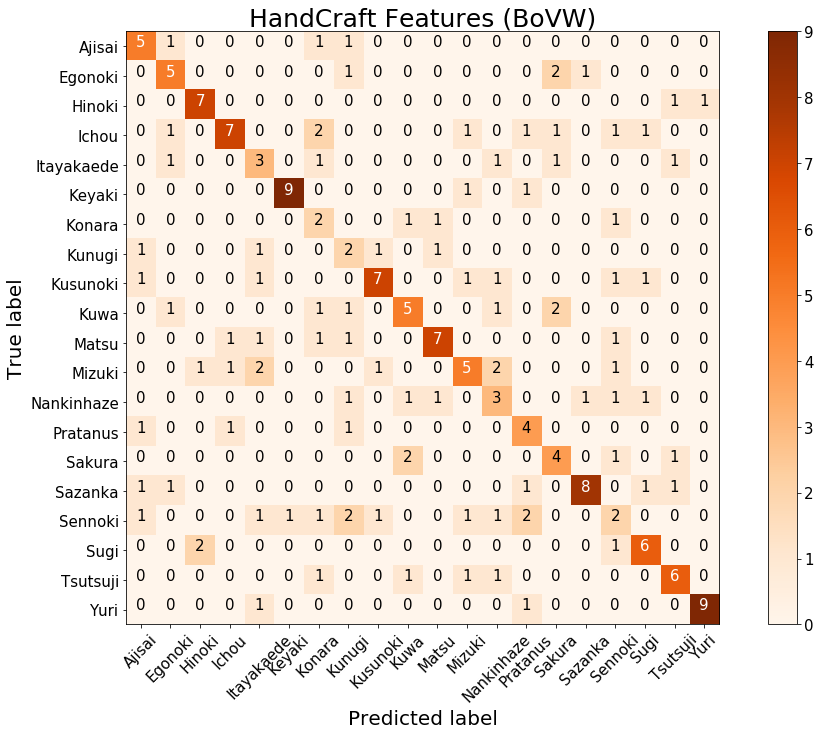

In [33]:
# BoVW特徴量での混合行列の計算と表示
actual = test_labels
s_cm = confusion_matrix(s_pred, actual)
plot_confusion_matrix(s_cm, classes=classes, title='HandCraft Features (BoVW)')
plt.show()

In [34]:
# BoVW特徴量だけでの全体の平均分類精度の計算
count = 0
total = len(actual)
for i in range(total):
    if actual[i] == s_pred[i]:
        count += 1
accuracy = float(count)/total
print("分類精度 (BoVW) = ",accuracy) 


分類精度 (BoVW) =  0.53


# 色テクスチャー特徴量とBoVW特徴量の混合

Mix i-feature + s-feature　→ si-feature

In [35]:
# 色テクスチャー特徴量とBoVW特徴量の積をとる
mix_pred_P = i_pred_P * s_pred_P
print('色とテクスチャ、ならびにBoVW特徴量の混合シェープ：',mix_pred_P.shape)

色とテクスチャ、ならびにBoVW特徴量の混合シェープ： (200, 20)


In [36]:
# 確率が最大となるクラスに分類し、ワンホットベクトルを生成
mix_pred = np.zeros((200,20),dtype=int)
for i in range(total):
    my = np.argmax(mix_pred_P[i])
    mix_pred[i][my] = 1

print(mix_pred)

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [37]:
# 確率そのものも最大となる確率を計算し、未知データ個々の予想クラスIDを生成
mix_prediction = np.zeros((200),dtype=int)
for i in range(200):
    my = np.argmax(mix_pred[i])
    mix_prediction[i] = my
print(mix_prediction)

[ 7  0  0 15  0  0  0  0 13  0  9  4  1  1  1  1  3  1  0  1  2  2  2 17
  2  2  2 11 17 17  3  3 11  3 10  3  3  3  3 13 19  4 12  8 16 11  4 10
  7  4  5  5  5 16  5  5  5  5  5  5  6  0  4 12 16  6  3  9 10  3  7 12
  7 13 16  5 10  1 16 13  8  7  1  7  8 16  8  8  5  8  9  9  9  9 14  9
  0  9  9  9 10 10  7 10 10  6 10 10 10  3 18 11 11 10 11 11 11  5  3 11
  7 12 12  8 11 11  9  9 16  4 13 13 16 13 16 19  3  5  3  9 14  3 14  3
 14 14  9 14 13  3 15 15 15 15 15 15 15 15 15 15  9  3 16 16 16 16 10 11
 14 17 17  8 15 17 17 17 12 17  3 17  0 18 18 18 18  2  4 18 14 18 19  4
 19 19  3 19 19 19 19 19]


In [38]:
# 色テクスチャー特徴量とBoVW特徴量との混合特徴量の全体的な平均精度を計算
count = 0
total = len(actual)
for i in range(total):
    if actual[i] == np.argmax(mix_pred[i]):
        count += 1
accuracy = float(count)/total
print("色＋テクスチャー＋BoVWの分類精度 = ",accuracy) # Previously 0.54

色＋テクスチャー＋BoVWの分類精度 =  0.56


In [39]:
# 色テクスチャー特徴量とBoVW特徴量との混合特徴量の確率値をNumpy形式で保存
np.save('npy/Python-ML-DL-Fusion-sifeature-predict.npy', mix_pred_P)


In [40]:
# エポック精度グラフ、エポック損失グラフの描画準備
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects
font_prop = fm.FontProperties() 
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')

fp2 = font_prop.copy()
fp2.set_size('20') # define a larger font
fp2.set_family('serif') # Serif font

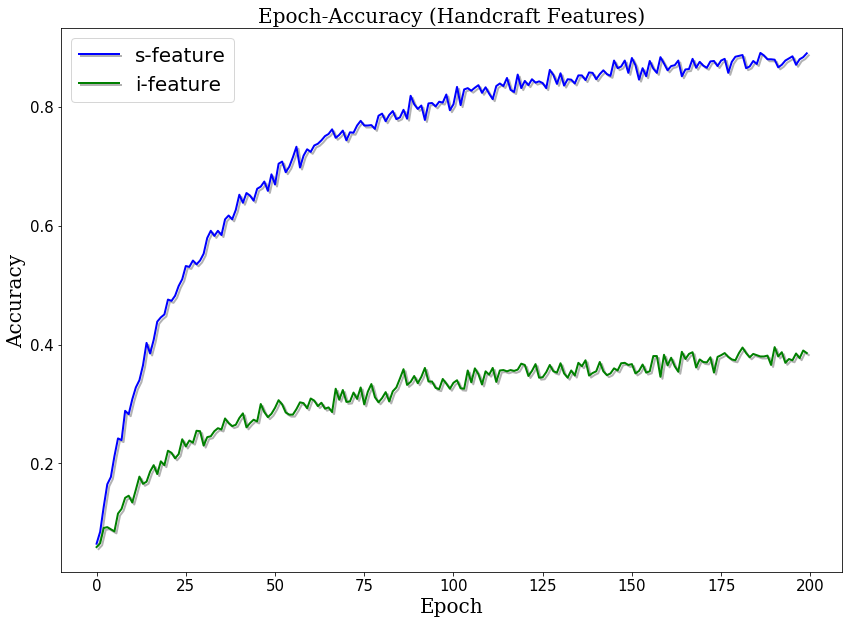

In [41]:
# エポック精度グラフの描画
# i-featureが色テクスチャー特徴量でのエポック精度グラフ
# s-featureがBoVW特徴量でのエポック精度グラフ
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))

plt.plot(s_fit.history['acc'], 
         color='b', 
         linestyle='-', 
         linewidth=2, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(i_fit.history['acc'], 
         color='g', 
         linestyle='-',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.title('Epoch-Accuracy (Handcraft Features)',fontsize=20,font_properties=fp2)
plt.ylabel('Accuracy',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['s-feature', 'i-feature'], loc='best',fontsize=20)

plt.tick_params(labelsize=15)
plt.savefig('images/Python-ML-DL-Fusion-SI-Accuracy.jpg')
plt.savefig('pdf/Python-ML-DL-Fusion-SI-Accuracy.pdf')

plt.show() 


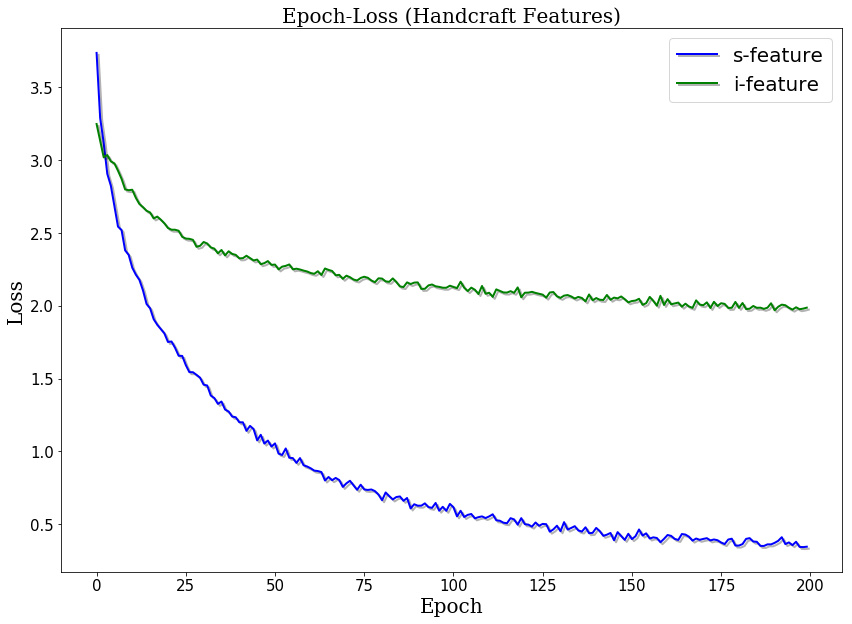

In [42]:
# エポック損失グラフの描画
# i-featureが色テクスチャー特徴量でのエポック損失グラフ
# s-featureがBoVW特徴量でのエポック損失グラフ
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))

plt.plot(s_fit.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=2, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(i_fit.history['loss'], 
         color='g', 
         linestyle='-',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.title('Epoch-Loss (Handcraft Features)',fontsize=20,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['s-feature', 'i-feature'], loc='best',fontsize=20)

plt.tick_params(labelsize=15)
plt.savefig('images/Python-ML-DL-Fusion-SI-Loss.jpg')
plt.savefig('pdf/Python-ML-DL-Fusion-SI-Loss.pdf')

plt.show() 

Confusion matrix, without normalization
[[ 7  1  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  1  0]
 [ 0  6  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  1  0  7  0  0  2  0  0  0  1  1  0  2  3  0  1  1  0  1]
 [ 0  1  0  0  3  0  1  0  0  0  0  0  1  0  0  0  0  0  1  1]
 [ 0  0  0  0  0  9  0  1  1  0  0  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  0  2  2  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  5  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  1  0  0  8  0  0  2  1  1  0  1  0  0  0]
 [ 0  0  0  1  1  0  1  1  0  0  7  1  0  0  0  0  1  0  0  0]
 [ 0  0  1  1  1  0  0  0  0  0  0  6  2  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  1  1  0  0  0  0  2  0  0  0  0  1  0  0]
 [ 1  0  0  1  0  0  0  2  0  0  0  0  0  3  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  5  0  1  0  1  0]
 [ 1  0  0  0  

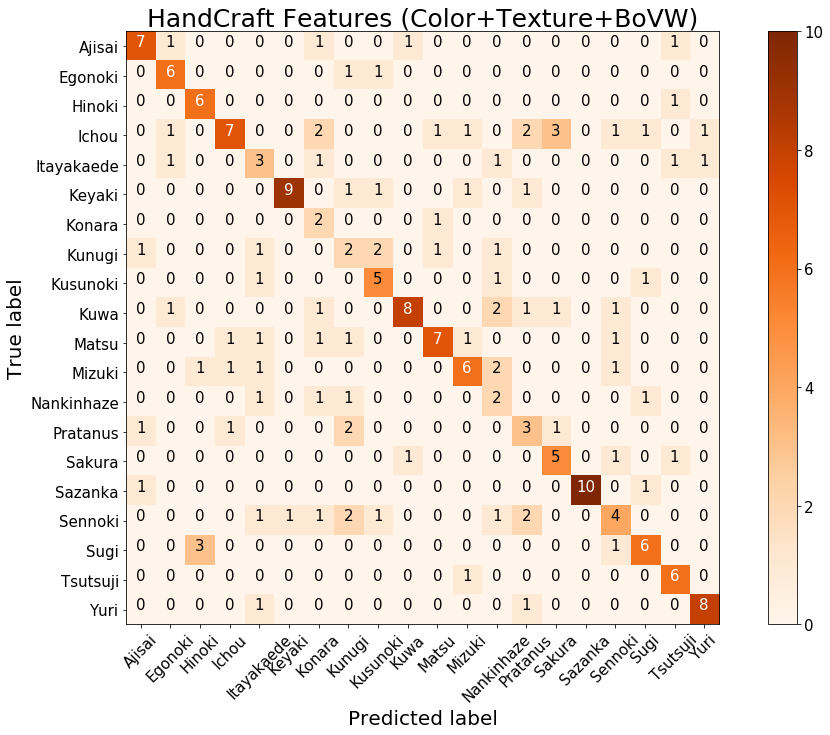

In [43]:
# 色テクスチャ特徴量(i-feature)とBoVW特徴量(s-feature)を連結した特徴量での混合行列
actual = test_labels
si_cm = confusion_matrix(mix_prediction, actual)
plot_confusion_matrix(si_cm, classes=classes, title='HandCraft Features (Color+Texture+BoVW)')
plt.show()

# ニューラルネットの代わりにBoVWをSVMで分類すると？

In [44]:
# SVMを利用した場合のBoVW特徴量での訓練
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
myFit = clf.fit(train_sfeatures, train_labels)


Confusion matrix, without normalization
[[7 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 5 0 0 0 1 0 1 0 2 1 0 0 0 1 1 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 5 0 3 0 0 0 0 0 0 0 0 2 0 1 0 1 0]
 [0 0 0 1 3 0 2 2 0 0 1 0 0 1 1 2 0 1 1 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 1 1 0 0 0]
 [0 0 0 0 1 0 2 0 2 2 1 0 0 1 0 0 0 0 0 0]
 [2 0 1 0 1 0 0 2 0 0 0 1 3 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 5 0 0 0 1 0 1 0 0 0 0 0]
 [0 2 0 0 0 0 1 0 0 4 0 0 1 0 2 0 2 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 6 0 0 0 0 0 1 0 0 1]
 [0 0 1 0 0 0 2 0 0 0 0 3 2 0 0 0 1 1 0 0]
 [0 0 0 0 2 1 0 1 0 0 1 1 2 0 0 1 1 0 0 0]
 [0 1 0 2 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 5 0 1 1 0]
 [0 0 0 0 1 0 1 2 0 0 0 0 0 2 1 0 1 1 0 0]
 [0 0 3 0 0 0 0 0 1 0 0 3 0 0 0 0 1 5 0 0]
 [0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 5 0]
 [0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 7]]


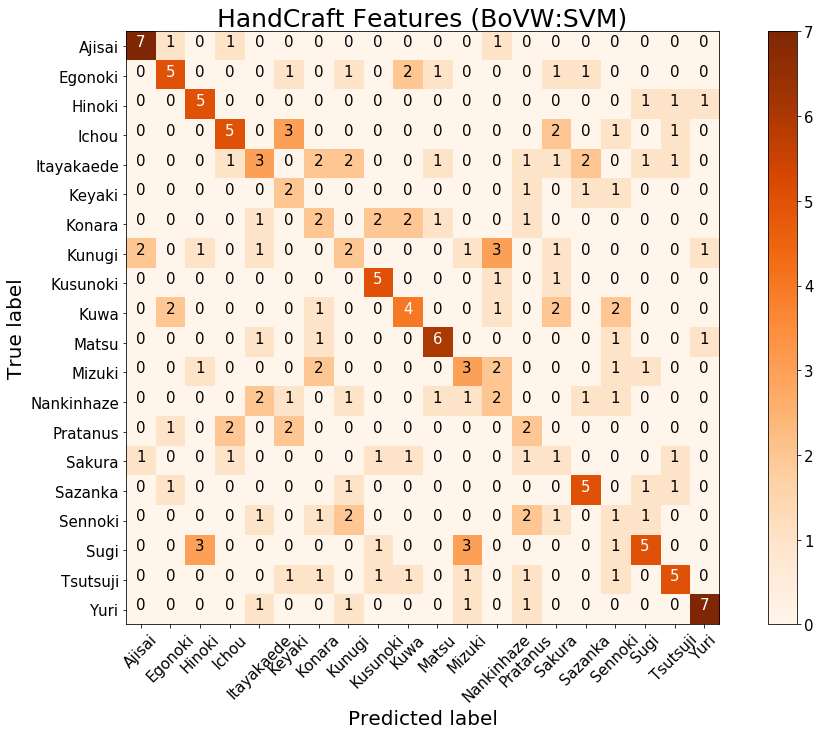

In [45]:
# 精度計算
predicted = clf.predict(test_sfeatures)

# BoVW特徴量をSVMで訓練した場合の混合行列
from sklearn.metrics import classification_report,confusion_matrix
actual = test_labels
svm_cm = confusion_matrix(predicted, actual) 
plot_confusion_matrix(svm_cm, classes=classes, title='HandCraft Features (BoVW:SVM)')
plt.show()

In [46]:
# BoVW特徴量をSVMで訓練した場合の平均精度
count = 0
total = len(actual)
for i in range(total):
    if actual[i] == predicted[i]:
        count += 1
accuracy = float(count)/total
print("BoVW特徴量のSVMでの分類精度 = ",accuracy) 

BoVW特徴量のSVMでの分類精度 =  0.385


# VGG16を訓練済みDNN (ImageNet)として利用

In [47]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
fc2_training = np.empty((0,4096),float)
base_model = VGG16(weights='imagenet')
pp_model = Model(inputs=base_model.input, 
              outputs=base_model.get_layer('fc2').output)

In [48]:
import os
print(os.getcwd())
os.chdir('C:/Users/Aono/DeepLearning/data/myPlantPhoto/Training') # Windowsの場合

classes = folders = ['Ajisai', 'Egonoki', 'Hinoki', 'Ichou', 'Itayakaede',
	'Keyaki', 'Konara', 'Kunugi', 'Kusunoki', 'Kuwa',
	'Matsu', 'Mizuki', 'Nankinhaze', 'Pratanus', 'Sakura',
	'Sazanka', 'Sennoki', 'Sugi', 'Tsutsuji', 'Yuri']
listAll = []
listIndex = []
total = 0
filecnt = 0
for folder in folders:
	flist = os.listdir(folder) # using os list directory
	length = len(flist)
	for i in range(length):
		listIndex.append(filecnt)
	total += len(flist)
	listAll.append(flist)
	filecnt += 1

print("total files = ",total)

C:\Users\Aono\DeepLearning
total files =  1400


In [49]:
# 時間がかかります
flat_list = [item for sublist in listAll for item in sublist]

# do training using pretrained network (takes some time) 
import numpy as np
fc2_training = np.empty((0,4096),float)

for i in range(len(flat_list)):
    if i % 400 == 0:
        print("Processing ...",(i+1)," data...")
    img_path = "all/"+flat_list[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    fc2_ft = pp_model.predict(x)
    fc2_ft = np.array(fc2_ft)
    fc2_training = np.append(fc2_training, fc2_ft,axis=0)

print (fc2_training.shape)
np.save('fc2_trainingVGG16.npy',fc2_training)


Processing ... 1  data...
Processing ... 401  data...
Processing ... 801  data...
Processing ... 1201  data...
(1400, 4096)


In [50]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

base_model = VGG16(weights='imagenet')
q_model = Model(inputs=base_model.input,
              outputs=base_model.get_layer('fc2').output)

q_model.summary()

train_truth = listIndex


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [51]:
os.chdir('C:/Users/Aono/DeepLearning/data/myPlantPhoto/Testing')# Windowsの場合
print(os.getcwd())


C:\Users\Aono\DeepLearning\data\myPlantPhoto\Testing


In [52]:
# query用 (未知)データをリストに代入
folders = ['Ajisai', 'Egonoki', 'Hinoki', 'Ichou', 'Itayakaede',
	'Keyaki', 'Konara', 'Kunugi', 'Kusunoki', 'Kuwa',
	'Matsu', 'Mizuki', 'Nankinhaze', 'Pratanus', 'Sakura',
	'Sazanka', 'Sennoki', 'Sugi', 'Tsutsuji', 'Yuri']
q_listAll = []
q_listIndex = []
q_total = 0
q_filecnt = 0
for folder in folders:
	q_flist = os.listdir(folder) # using os list directory
	length = len(q_flist)
	for i in range(length):
		q_listIndex.append(q_filecnt)
	q_total += len(q_flist)
	q_listAll.append(q_flist)
	q_filecnt += 1

In [53]:
# query全体を1画像あたり4096次元となるように、テストデータ数全部の特徴量を保持するリストに代入
q_flat_list = [item for sublist in q_listAll for item in sublist]
fc2_query200 = np.empty((0,4096),float)

for i in range(len(q_flat_list)):
	img_path = "all/"+q_flat_list[i] 
	img = image.load_img(img_path, target_size=(224, 224))
	x = image.img_to_array(img)
	x = np.expand_dims(x, axis=0)
	x = preprocess_input(x)
	fc2_ft = q_model.predict(x)
	fc2_ft = np.array(fc2_ft)
	fc2_query200 = np.append(fc2_query200, fc2_ft,axis=0)

print (fc2_query200.shape)


(200, 4096)


In [54]:
# ニューラルネットワークのモデル構築
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation 
import numpy as np
from keras.utils import np_utils 

a_model = Sequential()
a_model.add(Dense(256,input_dim=4096)) # 入力はVGG16から得た4096次元ベクトル
a_model.add(Activation('relu'))
a_model.add(Dropout(0.5))
a_model.add(Dense(20,activation='softmax')) # 20種類の植物のため、出力は20
a_compile = a_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 


In [55]:
# 未知データのラベル作成（ワンホットベクトル）
my_querylabel = np_utils.to_categorical(q_listIndex, NB_CLASSES)
print(my_querylabel.shape)

(200, 20)


In [56]:
# 訓練開始
NB_CLASSES = 20
my_label = np_utils.to_categorical(train_truth, NB_CLASSES)
a_fit = a_model.fit(fc2_training, my_label, 
                    epochs=150, batch_size=128, 
                    validation_data=(fc2_query200, my_querylabel)) 


Train on 1400 samples, validate on 200 samples
Epoch 1/150
1400/1400 [==============================] - 1s 790us/step - loss: 3.9957 - acc: 0.2464 - val_loss: 1.7222 - val_acc: 0.4950
Epoch 2/150
1400/1400 [==============================] - 0s 312us/step - loss: 1.7786 - acc: 0.4507 - val_loss: 1.4453 - val_acc: 0.6150
Epoch 3/150
1400/1400 [==============================] - 0s 306us/step - loss: 1.6162 - acc: 0.5264 - val_loss: 1.4180 - val_acc: 0.5850
Epoch 4/150
1400/1400 [==============================] - 0s 311us/step - loss: 1.3869 - acc: 0.5836 - val_loss: 1.0838 - val_acc: 0.6850
Epoch 5/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.1537 - acc: 0.6457 - val_loss: 1.0719 - val_acc: 0.6850
Epoch 6/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.0743 - acc: 0.6507 - val_loss: 1.0059 - val_acc: 0.7100
Epoch 7/150
1400/1400 [==============================] - 0s 168us/step - loss: 0.9613 - acc: 0.6929 - val_loss: 0.9427 - val_acc: 0

1400/1400 [==============================] - 0s 168us/step - loss: 0.0742 - acc: 0.9757 - val_loss: 1.0069 - val_acc: 0.8300
Epoch 61/150
1400/1400 [==============================] - 0s 167us/step - loss: 0.0557 - acc: 0.9829 - val_loss: 0.9919 - val_acc: 0.8300
Epoch 62/150
1400/1400 [==============================] - 0s 168us/step - loss: 0.0658 - acc: 0.9793 - val_loss: 0.9605 - val_acc: 0.8400
Epoch 63/150
1400/1400 [==============================] - 0s 167us/step - loss: 0.0810 - acc: 0.9743 - val_loss: 1.0451 - val_acc: 0.8150
Epoch 64/150
1400/1400 [==============================] - 0s 166us/step - loss: 0.0671 - acc: 0.9764 - val_loss: 0.8582 - val_acc: 0.8250
Epoch 65/150
1400/1400 [==============================] - 0s 167us/step - loss: 0.0692 - acc: 0.9786 - val_loss: 0.9039 - val_acc: 0.8450
Epoch 66/150
1400/1400 [==============================] - 0s 167us/step - loss: 0.0717 - acc: 0.9764 - val_loss: 1.0165 - val_acc: 0.7950
Epoch 67/150
1400/1400 [=======================

In [57]:
# クラスの予測
a_pred = a_model.predict_classes(fc2_query200, batch_size=128, verbose=1)
print(a_pred)

200/200 [==============================] - 0s 345us/step
[ 0  0  0  0  0  0  0  0  0 14  1  1  1  1  1  1  1  1  1  1  2  2  2 17
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3 14  7  4  4  4  4  4  4  4
  4  4  7  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  9 16  6  7  7
 12  7  7  7  7  7  6  7  8  4 16  4  8  8  8  8 10  8  9  9  9  9  1  9
  9  9  7  9 10 10 14 10 10 10 10 10 10 10 11 11  6 11 11 11 11 11  1 11
 12 12 12 10  7 13  1 12 12 12 13 13 13 13 16 13 13  9 13  1  6 14 14 14
  1 14 14 17 14 14 15 15 15 18 15 15 18 15 15 15 13 13 16 16 16 10 16 16
  7 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19]


Confusion matrix, without normalization
[[ 9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  1  0  1  1  1  1  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  1  0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1  0  8  0  1  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  8  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  9  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  7  0  0  2  0  0  0]
 [ 1  0  0  1  0  0  0  0  0  0  1  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  

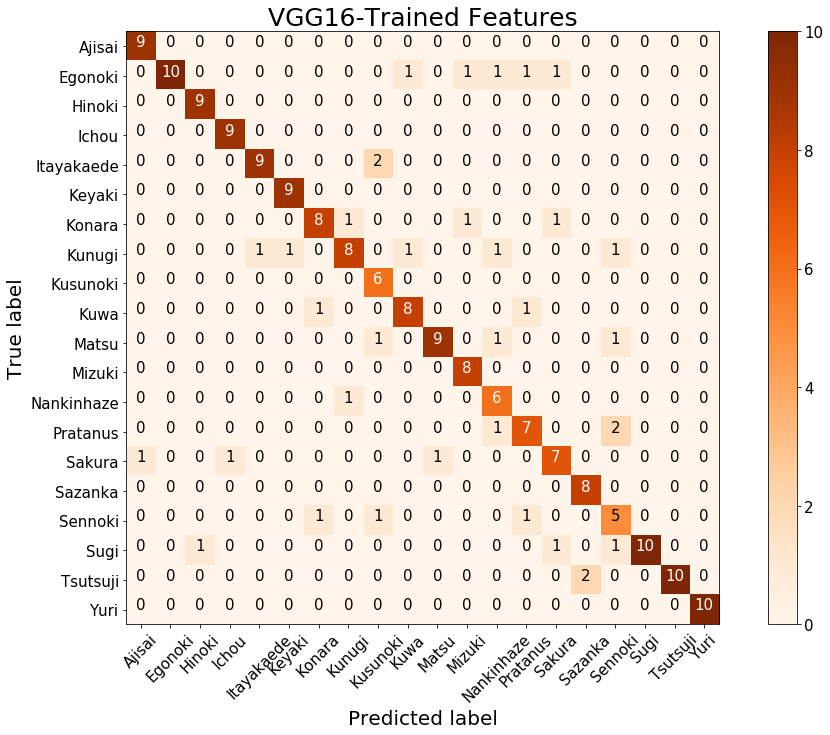

In [58]:
# VGG16特徴量で訓練したニューラルネットワークでの予測手法の混合行列計算と描画
test_truth = q_listIndex
a_actual = test_truth
a_cm = confusion_matrix(a_pred, a_actual) 
plot_confusion_matrix(a_cm, classes=classes, title='VGG16-Trained Features')
plt.show()

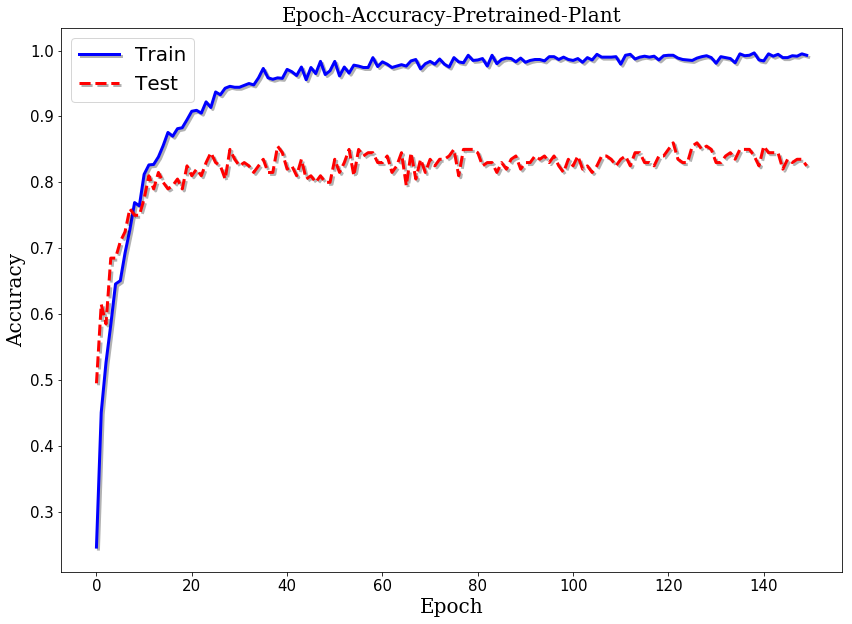

In [60]:
% matplotlib inline
import matplotlib.pyplot as plt

# 精度グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(a_fit.history['acc'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(a_fit.history['val_acc'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=15)
plt.title('Epoch-Accuracy-Pretrained-Plant',fontsize=25,font_properties=fp2)
plt.ylabel('Accuracy',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)

plt.savefig('Python-ML-DL-Fusion-Epoch-Accuracy-Pretrained.pdf')
plt.show()


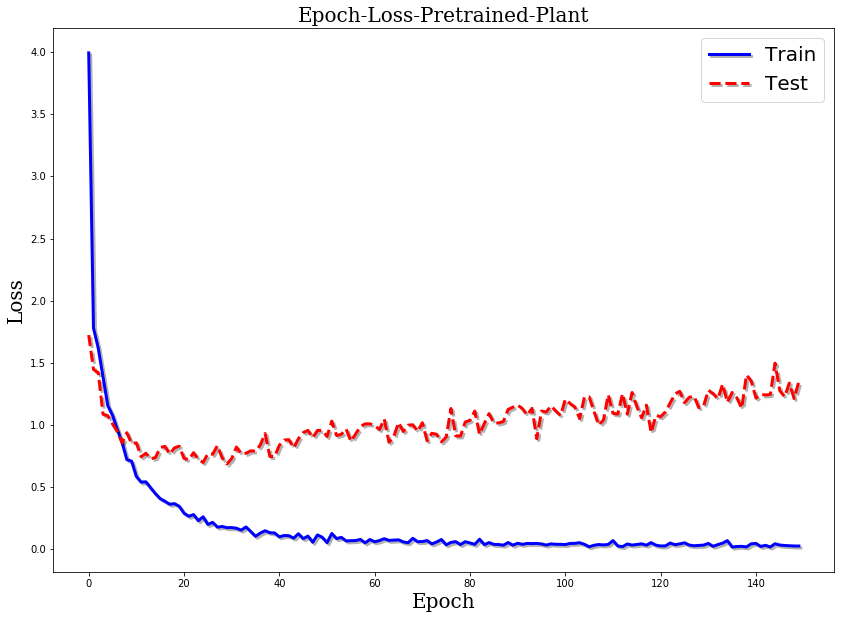

In [61]:
# 損失グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(a_fit.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(a_fit.history['val_loss'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.title('Epoch-Loss-Pretrained-Plant',fontsize=25,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)
plt.savefig('Python-ML-DL-Fusion-Epoch-Loss-Pretrained.pdf')
plt.show()

In [62]:
count = 0
total = len(a_actual)
for i in range(total):
    if a_actual[i] == a_pred[i]:
        count += 1
accuracy = float(count)/total
print("VGG16（訓練済み）特徴量を用いた植物画像の分類精度 = ",accuracy) 


VGG16（訓練済み）特徴量を用いた植物画像の分類精度 =  0.825


In [63]:
# VGG16特徴量で訓練したニューラルネットワークでの予測確率
a_pred_P = a_model.predict(fc2_query200, batch_size=128, verbose=1)
print(a_pred_P)

200/200 [==============================] - 0s 110us/step
[[1.00000000e+00 8.41475845e-20 1.19282713e-31 ... 1.49929414e-31
  4.47000932e-23 4.40056503e-27]
 [1.00000000e+00 8.41943747e-22 1.46440665e-31 ... 1.88239603e-30
  2.83289663e-19 1.83015629e-21]
 [1.00000000e+00 2.56542559e-28 9.71690661e-25 ... 2.92367957e-20
  4.85624878e-20 6.67445105e-26]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [3.53150311e-28 1.05385395e-19 3.17877660e-33 ... 1.66353138e-28
  7.65051542e-26 1.00000000e+00]
 [1.96568798e-30 8.62823762e-31 5.13077866e-38 ... 1.45663079e-36
  2.05248414e-31 1.00000000e+00]]


# 手作り特徴量(BoVW+色テクスチャー特徴量）+VGG特徴量

In [64]:
# 手作り特徴量(BoVW+色テクスチャー特徴量）+VGG特徴量を要素積でミックス
merged_pred_P = mix_pred_P * a_pred_P

In [65]:
# 全ミックス特徴量の平均精度
merged_pred = np.zeros((200,20),dtype=int)
for i in range(total):
    my = np.argmax(merged_pred_P[i])
    merged_pred[i][my] = 1

print(merged_pred)

count = 0
total = len(actual)
for i in range(total):
    if actual[i] == np.argmax(merged_pred[i]):
        count += 1
accuracy = float(count)/total
print("全特徴量をミックスした植物画像の分類精度 = ",accuracy)   

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
全特徴量をミックスした植物画像の分類精度 =  0.845


[ 0  0  0  0  0  0  0  0  0 14  1  1  1  1  1  1  1  1  1  1  2  2  2 17
  2  2  2 17  2  2  3  3  3  3 10  3  3  3  3 14  7  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  9  6  6  7  7
 12  7  7  7  7  1  6  7  8  4  8  4  8  8  8  8 10  8  9  9  9  9  9  9
  9  9  7  9 10 10  7 10 10 10 10 10 10 10 11 11  4 11 11 11 11 11  1 11
 12 12 12 10  7 12  9 12 12 12 13 13  1 13 16 13 13  9 13  1 14 14 14 14
  1 14 14 14 14 14 15 15 15 18 15 15 18 15 15 15 13 16 16 16 16  6 16 16
 14 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19]
Confusion matrix, without normalization
[[ 9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  1  0  0  0  1  0  2  1  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0 

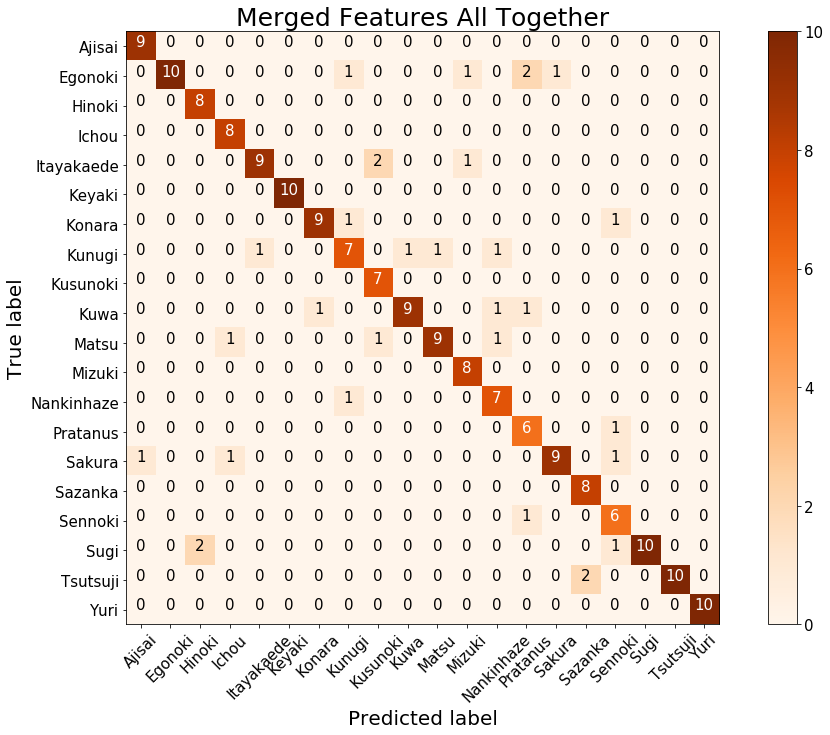

In [66]:
# ミックス特徴量の混合行列の計算と描画
merged_prediction = np.zeros((200),dtype=int)
for i in range(200):
    my = np.argmax(merged_pred[i])
    merged_prediction[i] = my
print(merged_prediction)
merged_cm = confusion_matrix(merged_prediction, actual) 
plot_confusion_matrix(merged_cm, classes=classes, title='Merged Features All Together')
plt.show()

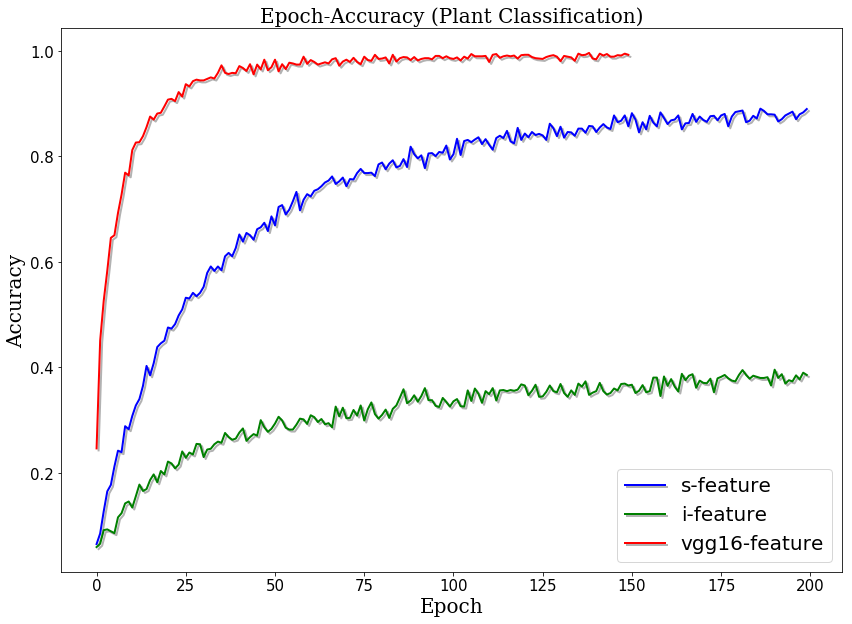

In [68]:
# 3種類の特徴量の同時プロット

# エポック精度グラフの描画
# i-featureが色テクスチャー特徴量でのエポック精度グラフ
# s-featureがBoVW特徴量でのエポック精度グラフ
# vgg16-feature特徴量でのエポック精度グラフ
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))

plt.plot(s_fit.history['acc'], 
         color='b', 
         linestyle='-', 
         linewidth=2, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(i_fit.history['acc'], 
         color='g', 
         linestyle='-',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(a_fit.history['acc'], 
         color='r', 
         linestyle='-',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])


plt.title('Epoch-Accuracy (Plant Classification)',fontsize=20,font_properties=fp2)
plt.ylabel('Accuracy',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['s-feature', 'i-feature', 'vgg16-feature'], loc='best',fontsize=20)

plt.tick_params(labelsize=15)
plt.savefig('Python-ML-DL-Fusion-Accuracy-All3-features.jpg')
plt.savefig('Python-ML-DL-Fusion-Accuracy-All3-features.pdf')
plt.show() 


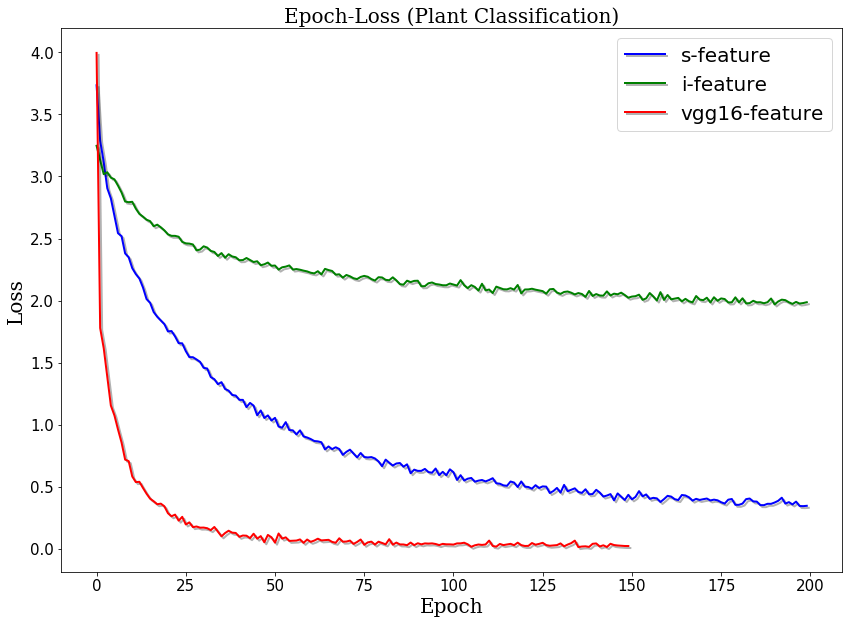

In [69]:
# エポック損失グラフの描画
# i-featureが色テクスチャー特徴量でのエポック損失グラフ
# s-featureがBoVW特徴量でのエポック損失グラフ
# vgg16-feature特徴量でのエポック損失グラフ
%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))

plt.plot(s_fit.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=2, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(i_fit.history['loss'], 
         color='g', 
         linestyle='-',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(a_fit.history['loss'], 
         color='r', 
         linestyle='-',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.title('Epoch-Loss (Plant Classification)',fontsize=20,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['s-feature', 'i-feature', 'vgg16-feature'], loc='best',fontsize=20)

plt.tick_params(labelsize=15)
plt.savefig('Python-ML-DL-Fusion-Loss-All3-features.jpg')
plt.savefig('Python-ML-DL-Fusion-Loss-All3-features.pdf')
plt.show() 

# 間違えたサンプル探し

In [70]:
# 予測を間違ったデータをプリント
print(merged_prediction)
index = 0
for i in range(20):
    for j in range(10):
        value = merged_prediction[index]
        if value != i:
            print(value," ",classes[i]," ",q_listAll[i][j])
        index += 1

[ 0  0  0  0  0  0  0  0  0 14  1  1  1  1  1  1  1  1  1  1  2  2  2 17
  2  2  2 17  2  2  3  3  3  3 10  3  3  3  3 14  7  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  9  6  6  7  7
 12  7  7  7  7  1  6  7  8  4  8  4  8  8  8  8 10  8  9  9  9  9  9  9
  9  9  7  9 10 10  7 10 10 10 10 10 10 10 11 11  4 11 11 11 11 11  1 11
 12 12 12 10  7 12  9 12 12 12 13 13  1 13 16 13 13  9 13  1 14 14 14 14
  1 14 14 14 14 14 15 15 15 18 15 15 18 15 15 15 13 16 16 16 16  6 16 16
 14 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19]
14   Ajisai   IMG_4563.jpg
17   Hinoki   DSC04702.jpg
17   Hinoki   DSC05535.jpg
10   Ichou   DSC04813.jpg
14   Ichou   IMG_4517.jpg
7   Itayakaede   10855_624.jpg
9   Konara   DSC05850.jpg
12   Kunugi   DSC01945.jpg
1   Kunugi   IMG_1216.jpg
6   Kunugi   IMG_4044.jpg
4   Kusunoki   DSC01173.jpg
4   Kusunoki   DSC03917.jpg
10   Kusunoki   IMG_4445.jpg
7   Kuwa   IMG_4614.jpg
7   Matsu   